# 设计卷积网络架构
:label:`sec_cnn-design`

前面的部分带我们了解了现代计算机视觉的网络设计。所有这些工作都有一个共同点，那就是它们在很大程度上依赖于科学家的直觉。许多架构都深受人类创造力的影响，而在很大程度上较少系统地探索深度网络提供的设计空间。尽管如此，这种*网络工程*方法非常成功。

自从AlexNet（:numref:`sec_alexnet`）在ImageNet上击败了传统的计算机视觉模型以来，通过堆叠相同模式设计的卷积块来构建非常深的网络变得流行起来。特别是，VGG网络（:numref:`sec_vgg`）使$3 \times 3$卷积变得流行。NiN（:numref:`sec_nin`）表明即使是$1 \times 1$卷积也可以通过增加局部非线性而有益。此外，NiN通过跨所有位置聚合信息解决了在网络头部聚合信息的问题。GoogLeNet（:numref:`sec_googlenet`）增加了不同卷积宽度的多个分支，在其Inception块中结合了VGG和NiN的优点。ResNets（:numref:`sec_resnet`）改变了对恒等映射的归纳偏置（从$f(x) = 0$）。这使得非常深的网络成为可能。近十年后，ResNet设计仍然流行，证明了其设计的成功。最后，ResNeXt（:numref:`subsec_resnext`）添加了分组卷积，提供了参数和计算之间的更好权衡。作为视觉变换器的先驱，挤压-激励网络（SENets）允许高效的信息传递:cite:`Hu.Shen.Sun.2018`。这是通过计算每个通道的全局注意力函数实现的。

到目前为止，我们忽略了通过*神经架构搜索*（NAS）获得的网络:cite:`zoph2016neural,liu2018darts`。我们选择这样做是因为它们的成本通常非常高，依赖于暴力搜索、遗传算法、强化学习或某种形式的超参数优化。给定一个固定的搜索空间，NAS使用一种搜索策略根据返回的性能估计自动选择架构。NAS的结果是一个单一的网络实例。EfficientNets是这种搜索的一个显著成果:cite:`tan2019efficientnet`。

接下来，我们将讨论一个与寻找*单一最佳网络*完全不同的想法。它在计算上相对便宜，能够带来科学上的见解，并且在结果质量方面非常有效。让我们回顾一下Radosavovic等人提出的*设计网络设计空间*的策略:citet:`Radosavovic.Kosaraju.Girshick.ea.2020`。该策略结合了手动设计和NAS的优势。它通过对*网络分布*进行操作并以优化整个网络家族性能的方式优化这些分布来实现这一点。它的结果是*RegNets*，特别是RegNetX和RegNetY，以及一系列用于设计高性能CNN的指导原则。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## AnyNet 设计空间
:label:`subsec_the-anynet-design-space`

以下描述紧密遵循 :citet:`Radosavovic.Kosaraju.Girshick.ea.2020` 的推理，并进行了一些简化以适应本书的范围。
首先，我们需要一个网络家族的模板。本章中设计的一个共同点是网络由 *stem*、*body* 和 *head* 组成。Stem 进行初始图像处理，通常通过较大窗口大小的卷积来实现。Body 由多个块组成，执行从原始图像到对象表示所需的大部分转换。最后，Head 将其转换为所需的输出，例如通过 softmax 回归器进行多类分类。
Body 反过来又由多个阶段组成，这些阶段在逐渐降低的分辨率下操作图像。实际上，Stem 和每个后续阶段都将空间分辨率降低四分之一。最后，每个阶段由一个或多个块组成。这种模式普遍存在于从 VGG 到 ResNeXt 的所有网络中。确实，对于通用 AnyNet 网络的设计，:citet:`Radosavovic.Kosaraju.Girshick.ea.2020` 使用了 :numref:`fig_resnext_block` 中的 ResNeXt 块。

![The AnyNet design space. The numbers $(\mathit{c}, \mathit{r})$ along each arrow indicate the number of channels $c$ and the resolution $\mathit{r} \times \mathit{r}$ of the images at that point. From left to right: generic network structure composed of stem, body, and head; body composed of four stages; detailed structure of a stage; two alternative structures for blocks, one without downsampling and one that halves the resolution in each dimension. Design choices include depth $\mathit{d_i}$, the number of output channels $\mathit{c_i}$, the number of groups $\mathit{g_i}$, and bottleneck ratio $\mathit{k_i}$ for any stage $\mathit{i}$.](../img/anynet.svg)
:label:`fig_anynet_full`

让我们详细回顾 :numref:`fig_anynet_full` 中概述的结构。如前所述，AnyNet 由 Stem、Body 和 Head 组成。Stem 以 RGB 图像（3 个通道）作为输入，使用步长为 2 的 $3 \times 3$ 卷积，后接批量归一化，将分辨率从 $r \times r$ 降至 $r/2 \times r/2$。此外，它生成 $c_0$ 个通道，作为 Body 的输入。

由于网络设计用于处理形状为 $224 \times 224 \times 3$ 的 ImageNet 图像，Body 通过 4 个阶段将其减少到 $7 \times 7 \times c_4$（回想一下 $224 / 2^{1+4} = 7$），每个阶段最终的步长为 2。最后，Head 采用完全标准的设计，通过全局平均池化（类似于 NiN (:numref:`sec_nin`)），后接全连接层，输出一个 $n$ 维向量用于 $n$ 类分类。

大多数相关的设计决策都内在于网络的 Body 部分。它按阶段进行，每个阶段由我们在 :numref:`subsec_resnext` 中讨论的相同类型的 ResNeXt 块组成。那里的设计再次完全是通用的：我们从一个步长为 2 的块开始（即 :numref:`fig_anynet_full` 中最右侧的块），该块将分辨率减半。为了匹配这一点，ResNeXt 块的残差分支需要通过一个 $1 \times 1$ 卷积。该块后面跟着数量可变的其他 ResNeXt 块，这些块保持分辨率和通道数不变。请注意，常见的设计实践是在卷积块的设计中添加一个小瓶颈。因此，通过瓶颈比 $k_i \geq 1$，我们可以在阶段 $i$ 的每个块中提供一些通道数 $c_i/k_i$（实验表明，这并不真正有效，应该跳过）。最后，由于我们处理的是 ResNeXt 块，我们还需要选择阶段 $i$ 的组卷积的组数 $g_i$。

这个看似通用的设计空间仍然为我们提供了许多参数：我们可以设置块宽度（通道数）$c_0, \ldots c_4$，每个阶段的深度（块数）$d_1, \ldots d_4$，瓶颈比 $k_1, \ldots k_4$，以及组宽（组数）$g_1, \ldots g_4$。
总共加起来有 17 个参数，导致需要探索的配置数量异常庞大。我们需要一些工具来有效地减少这个巨大的设计空间。这就是设计空间概念上的美妙之处。在这样做之前，让我们先实现通用设计。

In [2]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

每个阶段由`depth`个ResNeXt块组成，
其中`num_channels`指定了块的宽度。
请注意，第一个块会将输入图像的高度和宽度减半。

In [3]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

将网络的茎、主体和头部组合在一起，我们完成了AnyNet的实现。

In [4]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

## 分布和设计空间的参数

正如在 :numref:`subsec_the-anynet-design-space` 中讨论的那样，设计空间的参数是该设计空间中网络的超参数。
考虑在AnyNet设计空间中识别好的参数的问题。我们可以尝试找到给定计算量（例如，FLOPs和计算时间）下的*最佳*参数选择。如果我们允许每个参数只有*两个*可能的选择，那么为了找到最佳解决方案，我们需要探索$2^{17} = 131072$种组合。这显然是不可行的，因为成本过高。更糟糕的是，我们实际上并没有从这个练习中学到任何关于如何设计网络的知识。下次我们添加比如说X阶段、移位操作或类似的操作时，我们将需要从头开始。甚至更糟的是，由于训练中的随机性（舍入、洗牌、比特错误），两次运行不太可能产生完全相同的结果。一个更好的策略是尝试确定参数选择应该如何关联的一般指导原则。例如，瓶颈比率、通道数、块数、组数或它们在层之间的变化应该理想上由一组简单的规则来管理。:citet:`radosavovic2019network` 中的方法依赖于以下四个假设：

1. 我们假设确实存在一般的设计原则，因此许多满足这些要求的网络应提供良好的性能。因此，识别网络的*分布*可以是一种合理的策略。换句话说，我们认为干草堆中有许多好针。
1. 在能够评估一个网络是否良好之前，我们不必将网络训练至收敛。相反，使用中间结果作为最终准确性的可靠指导就足够了。使用（近似）代理来优化目标被称为多保真度优化 :cite:`forrester2007multi`。因此，基于仅通过数据集几次后的达到的准确性进行设计优化，大大降低了成本。
1. 在较小规模下获得的结果可以推广到更大规模。因此，对于结构相似但块数较少、通道数较少等的网络执行优化。最后，我们将需要验证这样找到的网络在大规模下也能提供良好的性能。
1. 设计的方面可以大致分解，以便能够在某种程度上独立地推断它们对结果质量的影响。换句话说，优化问题是相对容易的。

这些假设使我们能够廉价地测试许多网络。特别是，我们可以从配置空间中*均匀采样*并评估其性能。随后，我们可以通过回顾所述网络可以实现的误差/准确率的*分布*来评估参数选择的质量。令$F(e)$为给定设计空间中网络所犯错误的累积分布函数(CDF)，使用概率分布$p$绘制。即，

$$F(e, p) \stackrel{\textrm{def}}{=} P_{\textrm{net} \sim p} \{e(\textrm{net}) \leq e\}.$$

我们现在要找的是一个覆盖*网络*的分布$p$，使得大多数网络具有非常低的错误率，并且$p$的支持是简洁的。当然，准确执行这一点在计算上是不可行的。我们转而采用从$p$中抽取的网络样本$\mathcal{Z} \stackrel{\textrm{def}}{=} \{\textrm{net}_1, \ldots \textrm{net}_n\}$（分别具有误差$e_1, \ldots, e_n$）并使用经验CDF $\hat{F}(e, \mathcal{Z})$代替：

$$\hat{F}(e, \mathcal{Z}) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(e_i \leq e).$$

每当一组选择的CDF优于（或匹配）另一组选择的CDF时，它就表明其参数选择更好（或无差别）。因此
:citet:`Radosavovic.Kosaraju.Girshick.ea.2020` 实验了一种共享网络瓶颈比率$k_i = k$，用于网络的所有阶段$i$。这消除了控制瓶颈比率的四个参数中的三个。为了评估这种约束是否（负面）影响性能，可以从受约束和不受约束的分布中抽取网络并比较相应的CDF。事实证明，这种约束根本不影响网络分布的准确性，如:numref:`fig_regnet-fig` 的第一面板所示。
同样，我们可以选择在网络的不同阶段选取相同的组宽度$g_i = g$。再次，这不影响性能，如:numref:`fig_regnet-fig` 的第二面板所示。
这两个步骤结合起来减少了六个自由参数。

![比较设计空间的误差经验分布函数。$\textrm{AnyNet}_\mathit{A}$ 是原始设计空间；$\textrm{AnyNet}_\mathit{B}$ 绑定了瓶颈比率，$\textrm{AnyNet}_\mathit{C}$ 也绑定了组宽度，$\textrm{AnyNet}_\mathit{D}$ 增加了跨阶段的网络深度。从左到右：(i) 绑定瓶颈比率对性能没有影响；(ii) 绑定组宽度对性能没有影响；(iii) 跨阶段增加网络宽度（通道）提高了性能；(iv) 跨阶段增加网络深度提高了性能。图片来自 :citet:`Radosavovic.Kosaraju.Girshick.ea.2020`。](../img/regnet-fig.png)
:label:`fig_regnet-fig`

接下来我们寻找减少阶段宽度和深度多种潜在选择的方法。一个合理的假设是，随着我们深入网络，通道数应该增加，即$c_i \geq c_{i-1}$（按照他们在:numref:`fig_regnet-fig`中的表示方法为$w_{i+1} \geq w_i$），从而得到$\textrm{AnyNetX}_D$。同样合理的是假设随着阶段的推进，它们应该变得更深，即$d_i \geq d_{i-1}$，从而得到$\textrm{AnyNetX}_E$。这可以在:numref:`fig_regnet-fig` 的第三和第四面板中分别实验验证。

## RegNet

由此产生的$\textrm{AnyNetX}_E$设计空间包含遵循易于理解的设计原则的简单网络：

* 对所有阶段$i$共享瓶颈比率$k_i = k$；
* 对所有阶段$i$共享组宽度$g_i = g$；
* 跨阶段增加网络宽度：$c_{i} \leq c_{i+1}$；
* 跨阶段增加网络深度：$d_{i} \leq d_{i+1}$。

这给我们留下了最后一组选择：如何为上述最终$\textrm{AnyNetX}_E$设计空间的参数挑选具体值。通过研究$\textrm{AnyNetX}_E$分布中表现最好的网络，可以观察到以下情况：理想情况下，网络的宽度随着整个网络中的块索引线性增加，即$c_j \approx c_0 + c_a j$，其中$j$是块索引，斜率$c_a > 0$。鉴于我们只能每阶段选择不同的块宽度，我们得到了一个分段常数函数，旨在匹配这种依赖关系。此外，实验还显示瓶颈比率为$k = 1$时表现最好，即建议根本不要使用瓶颈。

我们建议感兴趣的读者通过阅读 :citet:`Radosavovic.Kosaraju.Girshick.ea.2020` 来了解更多关于针对不同计算量设计特定网络的细节。例如，一个有效的32层RegNetX变体由$k = 1$（无瓶颈）、$g = 16$（组宽为16）、$c_1 = 32$ 和 $c_2 = 80$ 分别为第一和第二阶段的通道数，以及选择$d_1=4$ 和 $d_2=6$ 块深。令人惊讶的是，即使在研究更大规模的网络时，这一设计仍然适用。甚至更好，它也适用于具有全局通道激活的Squeeze-and-Excitation (SE) 网络设计（RegNetY）:cite:`Hu.Shen.Sun.2018`。

In [5]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

我们可以看到，每个RegNetX阶段逐步降低分辨率并增加输出通道。

In [6]:
RegNetX32().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


## 训练

在Fashion-MNIST数据集上训练32层的RegNetX就像之前一样。

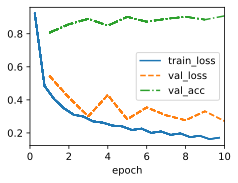

In [7]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

## 讨论

具有像局部性和平移不变性（:numref:`sec_why-conv`）这样理想的归纳偏差，CNNs 一直是该领域的主导架构。从 LeNet 到 Transformers (:numref:`sec_transformer`) :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021,touvron2021training` 在准确性上超越 CNNs 之前，情况一直如此。尽管最近在视觉 Transformers 方面的许多进展 *可以* 回传到 CNNs :cite:`liu2022convnet` 中，但这只能以更高的计算成本为代价。同样重要的是，最近的硬件优化（NVIDIA Ampere 和 Hopper）进一步扩大了有利于 Transformers 的差距。

值得注意的是，Transformers 对局部性和平移不变性的归纳偏差程度明显低于 CNNs。学习结构之所以占优势，至少部分原因是由于大规模图像集合的可用性，例如 LAION-400m 和 LAION-5B :cite:`schuhmann2022laion`，其中包含多达50亿张图像。相当令人惊讶的是，在这种情况下，一些更相关的工作甚至包括 MLPs :cite:`tolstikhin2021mlp`。

总之，视觉 Transformers (:numref:`sec_vision-transformer`) 现在在大规模图像分类方面处于领先地位，表明 *可扩展性优于归纳偏差* :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。这包括使用多头自注意力 (:numref:`sec_multihead-attention`) 预训练大规模 Transformers (:numref:`sec_large-pretraining-transformers`)。我们邀请读者深入这些章节进行更详细的讨论。

## 练习

1. 将阶段数量增加到四个。你能设计一个更深的 RegNetX 来提高性能吗？
1. 通过将 ResNeXt 块替换为 ResNet 块来取消 RegNets 的 ResNeXt 化。你的新模型表现如何？
1. 通过 *违反* RegNetX 的设计原则来实现多个 "VioNet" 家族实例。它们的表现如何？($d_i$, $c_i$, $g_i$, $b_i$) 中哪个因素最重要？
1. 你的目标是设计“完美”的 MLP。你能使用上述设计原则找到好的架构吗？能否从小型网络外推到大型网络？

[讨论](https://discuss.d2l.ai/t/7463)